In [ ]:
!mkdirv ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download dhoogla/cicids2017

/bin/bash: line 1: mkdirv: command not found
cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/dhoogla/cicids2017
License(s): CC-BY-NC-SA-4.0
 96% 217M/227M [00:02<00:00, 124MB/s]
100% 227M/227M [00:02<00:00, 100MB/s]


In [ ]:
!unzip /content/cicids2017.zip -d /content/dataset

Archive:  /content/cicids2017.zip
  inflating: /content/dataset/Benign-Monday-no-metadata.parquet  
  inflating: /content/dataset/Botnet-Friday-no-metadata.parquet  
  inflating: /content/dataset/Bruteforce-Tuesday-no-metadata.parquet  
  inflating: /content/dataset/DDoS-Friday-no-metadata.parquet  
  inflating: /content/dataset/DoS-Wednesday-no-metadata.parquet  
  inflating: /content/dataset/Infiltration-Thursday-no-metadata.parquet  
  inflating: /content/dataset/Portscan-Friday-no-metadata.parquet  
  inflating: /content/dataset/WebAttacks-Thursday-no-metadata.parquet  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import layers, Sequential, Layer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.initializers import GlorotUniform, HeUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tf2onnx
import onnx

In [ ]:
df_1 = pd.read_parquet('/content/dataset/Benign-Monday-no-metadata.parquet')
df_2 = pd.read_parquet('/content/dataset/Botnet-Friday-no-metadata.parquet')
df_3 = pd.read_parquet('/content/dataset/Bruteforce-Tuesday-no-metadata.parquet')
df_4 = pd.read_parquet('/content/dataset/DDoS-Friday-no-metadata.parquet')
df_5 = pd.read_parquet('/content/dataset/DoS-Wednesday-no-metadata.parquet')
df_6 = pd.read_parquet('/content/dataset/Infiltration-Thursday-no-metadata.parquet')
df_7 = pd.read_parquet('/content/dataset/Portscan-Friday-no-metadata.parquet')
df_8 = pd.read_parquet('/content/dataset/WebAttacks-Thursday-no-metadata.parquet')

In [ ]:
df_data  = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8])

In [ ]:
print("Null values are",df_data.isnull().sum().sum())
df_data.dropna(inplace=True)
print("Number of Duplicates are",df_data.duplicated().sum())
df_data.drop_duplicates(inplace=True)
df_data.reset_index(drop=True, inplace=True)
print("Categorical column are", df_data.select_dtypes(include=['object']).columns.tolist())

Null values are 0
Number of Duplicates are 82004
Categorical column are ['Label']


In [ ]:
df_data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,4,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
2,6,3,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3,6,1,2,0,12,0,6,6,6.00000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
4,6,609,7,4,484,414,233,0,69.14286,111.967896,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [ ]:
df_data["Label"].value_counts()

,count
Label,
Benign,1895314
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
columns = ["Flow Duration", "Total Fwd Packets", "Fwd Packet Length Min", "Fwd Packet Length Max",
           "Fwd Packet Length Std", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max",
           "Fwd Header Length", "Fwd Act Data Packets", "FIN Flag Count", "Packet Length Std", "Avg Packet Size", "Label"]
df_data = df_data[columns]
df_data.head()

,Flow Duration,Total Fwd Packets,Fwd Packet Length Min,Fwd Packet Length Max,Fwd Packet Length Std,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd Header Length,Fwd Act Data Packets,FIN Flag Count,Packet Length Std,Avg Packet Size,Label
0,4,2,6,6,0.000000,4,4.0,0.000000,4,40,1,0,0.000000,9.00000,Benign
1,1,2,6,6,0.000000,1,1.0,0.000000,1,40,1,0,0.000000,9.00000,Benign
2,3,2,6,6,0.000000,3,3.0,0.000000,3,40,1,0,0.000000,9.00000,Benign
3,1,2,6,6,0.000000,1,1.0,0.000000,1,40,1,0,0.000000,9.00000,Benign
4,609,7,0,233,111.967896,609,101.5,177.089523,460,164,5,0,107.527443,81.63636,Benign


In [ ]:
X = df_data.copy()
Y = X.pop("Label")
Y = Y.map({'Benign': 0}).fillna(1)

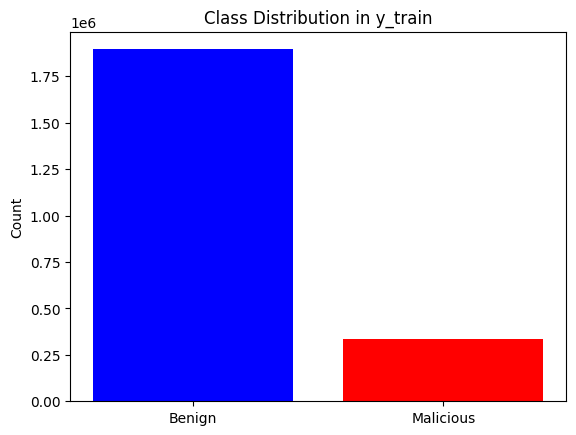

Class 0 ratio: 84.92%
Class 1 ratio: 15.08%


In [ ]:
class_counts = np.bincount(Y)
plt.bar([0, 1], class_counts, color=['blue', 'red'])
plt.xticks([0, 1], ['Benign', 'Malicious'])
plt.ylabel('Count')
plt.title('Class Distribution in y_train')

plt.show()

class_counts = Y.value_counts()
class_ratios = class_counts / len(Y)

print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X,Y,
                                                        stratify=Y,
                                                        test_size=(1.0 - 0.75),
                                                        random_state=1287,
                                                        shuffle=True)
fraction = 0.15 / (0.10 + 0.15)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
                                                      test_size=fraction,
                                                      random_state=1287,
                                                      shuffle=True)

In [ ]:
y_test

,Label
2018239,0.0
1398132,1.0
950041,0.0
1688528,0.0
274404,0.0
...,...
1971495,0.0
801605,0.0
1884742,0.0
1113063,1.0


In [ ]:
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

In [ ]:
# smote = SMOTE(sampling_strategy=0.5, random_state=1287)
smote = SMOTE(sampling_strategy=0.8, random_state=1287)
X_train, y_train = smote.fit_resample(X_train, y_train)

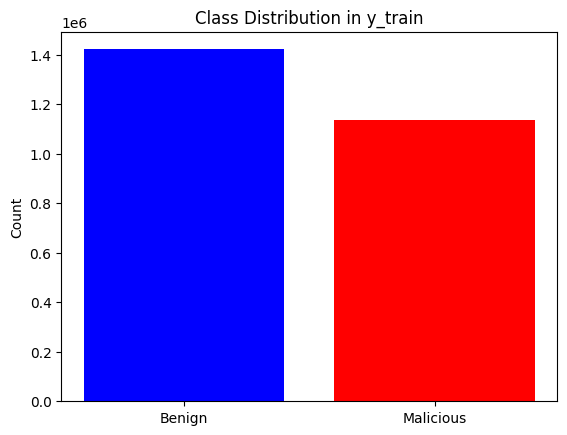

Class 0 ratio: 55.56%
Class 1 ratio: 44.44%


In [ ]:
class_counts = np.bincount(y_train)
plt.bar([0, 1], class_counts, color=['blue', 'red'])
plt.xticks([0, 1], ['Benign', 'Malicious'])
plt.ylabel('Count')
plt.title('Class Distribution in y_train')

plt.show()

class_counts = y_train.value_counts()
class_ratios = class_counts / len(y_train)

print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
mean = scaler.mean_
std = scaler.scale_

scaler_params = {
    "mean": mean.tolist(),
    "std": std.tolist()
}

with open("scaler_params.json", "w") as f:
    json.dump(scaler_params, f)

In [ ]:
input_shape = X_train.shape[1]

model = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='sigmoid', kernel_initializer=GlorotUniform()),
    Dense(8,  activation='relu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='relu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='relu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform(), name='output')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 425 (1.66 KB)

 Trainable params: 425 (1.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 5,
    min_lr=1e-07,
    verbose=5,
    factor=0.1)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=250, verbose=1, batch_size=1024,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8124 - loss: 0.4594 - val_accuracy: 0.9002 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 2/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9030 - loss: 0.2490 - val_accuracy: 0.9051 - val_loss: 0.2226 - learning_rate: 0.0010
Epoch 3/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9133 - loss: 0.2185 - val_accuracy: 0.9139 - val_loss: 0.1992 - learning_rate: 0.0010
Epoch 4/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9189 - loss: 0.2059 - val_accuracy: 0.9220 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 5/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9211 - loss: 0.1982 - val_accuracy: 0.9218 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 6/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9228 - loss: 0.1935 - val_accuracy: 0.9177 - val_loss: 0.1938 - learning_rate: 0.0010
Epoch 7/250
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall:    {recall*100:.2f}%")
print(f"Test F1 Score:  {f1*100:.2f}%")

10462/10462 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9438 - loss: 0.1381
10462/10462 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Test Loss:      0.1386
Test Accuracy:  94.38%
Test Precision: 75.88%
Test Recall:    91.90%
Test F1 Score:  83.13%


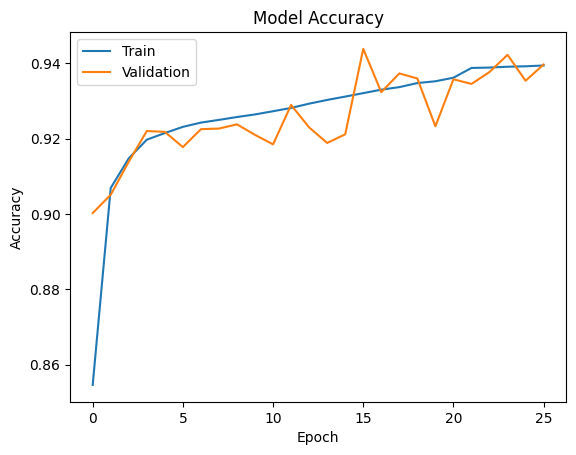

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

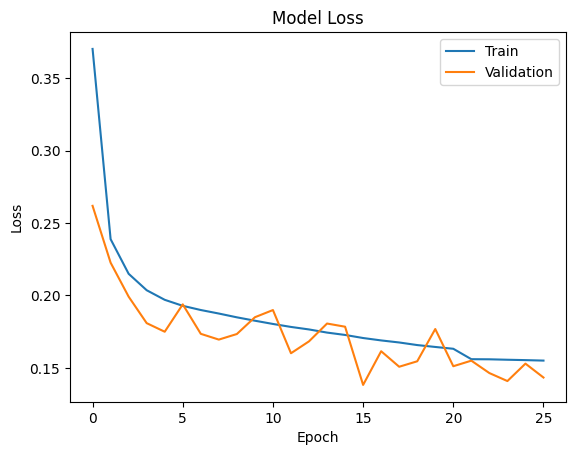

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt

In [ ]:
x_test_selected = X_test[y_test == 1]
y_test_selected = y_test[y_test == 1]

In [ ]:
x_test_selected[0:5]

array([[-0.80651816, -0.34116991, -0.31666126, -0.32794844, -0.10828307,
         0.78342678, -0.04399446,  0.957781  ,  1.11925036, -0.35142477,
        -0.25316221, -0.02987198, -0.29992719, -0.34948723],
       [-0.79055152, -0.34116748, -0.31666126, -0.327953  , -0.10829082,
         0.79264221, -0.1488217 ,  0.82523109,  1.12946812, -0.35142164,
        -0.2531617 , -0.02987198, -0.29990396, -0.34948282],
       [-0.77047086, -0.34116834, -0.31666126, -0.32795976, -0.10828781,
         0.81383948, -0.28580983,  0.62233343,  1.13330889, -0.35142324,
        -0.2531553 , -0.02987198, -0.29995943, -0.34950104],
       [ 1.34401163, -0.34084223, -0.31666126, -0.32778182, -0.10800555,
        -1.27728963, -0.7902122 , -0.94251799, -1.16564906, -0.35111637,
        -0.25252911, -0.02987198, -0.27028987, -0.3404832 ],
       [-0.8508168 , -0.34113657, -0.31665604, -0.32798166, -0.10832666,
         0.74386577,  0.31307436,  1.3480123 ,  1.07538644, -0.35140204,
        -0.25307309, -0.02

In [ ]:
model.evaluate(x_test_selected, y_test_selected)

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9180 - loss: 0.2425


[0.24251636862754822, 0.9189879894256592]

In [ ]:
input_signature = [tf.TensorSpec([None, input_shape], tf.float32, name="input")]

model.output_names=["output"]

onnx_model, _ = tf2onnx.convert.from_keras(
        model,
        input_signature=input_signature,
        opset=13 ,
        output_path="network_detection_model.onnx"
    )